## Introduction
This post provides a few examples of speed optimizations in python with numba package. I will compare different approaches for performing computations based on vectors and 'for loops'. Here I will mostly compare pure python code against numpy and numba decorator.

For more information regarding numba package, please check the following links:

* [Speed Up your Algorithms Part 2— Numba](https://towardsdatascience.com/speed-up-your-algorithms-part-2-numba-293e554c5cc1)
* [Numba faster than fortran](https://jekel.me/2017/Python-with-Numba-faster-than-fortran/)
* [numba vs cython take 2](https://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2/)
* [Accelerating python with numba](https://anaconda.org/ijstokes/accelerating-python-with-numba/notebook)
* [speed gain and tutorial numpy and numba](http://numba.pydata.org/numba-doc/0.12/tutorial_numpy_and_numba.html)

Numba is a library that is used for speeding up computations of python code. It is achieved by compiling selected function to the compiled code, thus increasing speed performance.  
Numba has two compilation modes: *nopython=True* mode, which is recommended one and object mode. The former produces much faster code, but will throws error if any of the function or method could not be compiled by numba. Then one can fall back to the latter one, where partial optimization is performed (not recommended).

For convenience, among others, numba provides two decorators which can be used for speeding up your code. The first one is **@jit**, the other one is **@njit**. The difference between those two is that **@njit = @jit(nopython=True)**, just for easier use. Thus **@njit** is preferred execution, since it will fore the whole function to be compiled.
Usage of the decorator is as simple as follows:

```python
@njit
def foo(x):
    b = 0
    for i in range(x):
        b = b + i  
    return b
        
foo(100)
```

For Data Scientist, very important factor is, whether numba supports numpy functions. Luckily, out of the box numba supports quite long list of the numpy functions. The complete list of supported functions you can check [numba supported functions](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html).

In the this article, I will show some code examples on which execution speed of differently implemented functions will be compared. Here, I will compare three different codes categories: regular python code, numpy code and those functions boosted by the numba decorator. 

To be honest, I am aware, that the results presented here are not representative for all tasks and conditions - nevertheless I believe that it is beneficial at least to consider using numba decorator, since it can provide significant speed gain by simply decorating the called function.

In the first example we will compare different methods of calculating Mean Squared Error/Difference (MSE). Thus I will calculate difference between two matrices, then differences will be squared and then average value will be returned.  
Here the following three approaches will be compared:
* pure python
* based on numpy functions
* as above but with numba complier

## Importing libraries

In [62]:
import numpy as np
import pandas as pd
import numba
from numba import njit, jit, prange
import time as time
from timeit import default_timer as timer
%matplotlib inline

## MSE example
The first implemented function named "python_01" is based on pure python functions and objects, with double for loop, and in each iteration a new value is assigned to the variable "z". The second one named "python_02" uses inplace substitution for the "z" variable for better efficiency.

In [63]:
def python_01(X, Y):
    i_list = range(X.shape[0])
    j_list = range(X.shape[1])
    k = 0
    for i in i_list:
        z = 0
        for j in j_list:
            z = z + (X[i,j] - Y[i,j])**2
        k = k + z
    return k / (X.shape[0] * X.shape[1])

def python_02(X, Y):
    i_list = range(X.shape[0])
    j_list = range(X.shape[1])
    k = 0
    for i in i_list:
        z=0
        for j in j_list:
            z += (X[i,j] - Y[i,j])**2
        k += z
    return k / (X.shape[0] * X.shape[1])

The two examples below, are the implementations of the MSE based on the numpy package, without any explicit for loops (vectorized calculations). Thus calculation speed should be significantly better as compared to pure python code. The two numpy version differ on how the squared values are calculated, the first one uses python power operator "**", while the latter one uses "numpy.power()" function.

In [64]:
def numpy_01(X, Y):
    dist = (np.power((X - Y), 2)).sum()
    return dist / (X.shape[0] * X.shape[1])

def numpy_02(X, Y):
    dist = ((X - Y)**2).sum()
    return dist / (X.shape[0] * X.shape[1])

Lastly the examples below are based on the functions defined as above, but additionally they are decorated with **@njit** decorators, which forces the whole function to be converted into compiled code.

In [65]:
@njit
def numba_01(X, Y):
    i_list = range(X.shape[0])
    j_list = range(X.shape[1])
    k = 0
    for i in i_list:
        z = 0
        for j in j_list:
            z = z + (X[i,j] - Y[i,j])**2
        k = k + z
    return k / (X.shape[0] * X.shape[1])

@njit
def numba_02(X, Y):
    i_list = range(X.shape[0])
    j_list = range(X.shape[1])
    k = 0
    for i in i_list:
        z = 0
        for j in j_list:
            z += (X[i,j]- Y[i,j])**2
        k += z
    return k / (X.shape[0] * X.shape[1]) 

@njit
def numba_03(X, Y):
    dist = (np.power((X - Y), 2)).sum()
    return dist / (X.shape[0] * X.shape[1])

@njit
def numba_04(X, Y):
    dist = ((X - Y)**2).sum()
    return dist / (X.shape[0] * X.shape[1])

In order to profile execution times of each of the functions above a helper function named "time_compared" is provided.

In all cases first both random matrices of the size: 1000x1000 will be generated (to exclude data generation from the MSE calculation), and then actual MSE calculation will be time profiled.

One important comment: due to the fact, that numba is "just in time complier", the code is not compiled until the first execution of the code. Thus when the function decorated with @numba is called for the first time, then the compiler gets into action and then compiles the function. Thus the first execution of such function will be significantly longer as compared to the next calls to this same function.  
In order to properly time the execution of the function, in the "time_compare" function, there is additional call to the profiled function - which is not timed. It forces the compiler to do its job, and then function can be properly timed on the following calls.  

Additional function, called "plot_speeds" is used just for the speed visualization purposes.

In [66]:
def time_compare(funcs, rows, cols, n_runs = 5):
    funcs_arr = []
    times_arr = []
    for func in funcs:
        time_tot = 0
        np.random.seed(0) 
        X = np.random.rand(rows, cols)
        np.random.seed(1) 
        Y = np.random.rand(rows, cols)
        res = func(X,Y) #Initial execution, to force function comilation 
        for i in range(n_runs):
            np.random.seed(i) 
            start_time = timer()
            func(X,Y)
            time_tot = time_tot + timer() - start_time
        times_arr = np.append(times_arr, time_tot/n_runs)
        funcs_arr = np.append(funcs_arr, func.__name__)       
    return pd.DataFrame([times_arr.T], columns=funcs_arr).transpose()

def plot_speeds(df):
    max_time = df.max()[0]
    df2 = max_time/df
    
    from matplotlib import pyplot as plt
    ax= df2.plot.bar(figsize=(10,5), legend = False);
    ax.set_title("Execution time for different functions (longest running time = {:.2f} s)".format(max_time))
    ax.set_yscale("log")
    ax.set_ylabel("Relative speed");
    ax.set_ylim(.5,df2.max()[0]*2)

    x = range(df2.index.size)
    y = df2[0].values
    for i,j in zip(x,y):
        ax.annotate("{:.0f}".format(j),xy=(i - 0.1, j * 1.1))

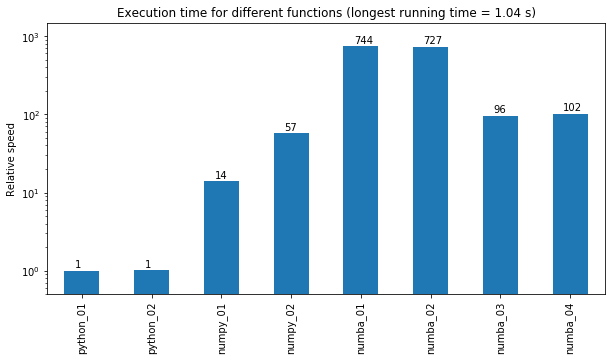

In [71]:
profile_MSE = [python_01, python_02, numpy_01, numpy_02, numba_01, numba_02, numba_03, numba_04]
speeds_MSE = time_compare(profile_MSE, 100, 10000, n_runs=5)
plot_speeds(speeds_MSE)

Observing the results provided in the graph above, the following observations can be made:
* both pure python versions runs with similar speed
* numpy with python square using np.power() function is 15 times faster
* numpy with python square using "**" power operator is 59 times faster
* numba with pure python underlying code (regardless if it uses inplace assignment or not) is around **750** faster!
* numba code is **14** times faster as compared to numpy code!
* numba with numpy underlying code 100 times faster, still 7 times slower than in previous case!

The following conclusion can be made: when using numba decorator, it is advantageous to use pure python code under the hood, most likely it enables the compiler make better optimization. Moreover numba provides almost three orders of magnitude speed-up (**750** times faster) over pure (unvectorized) python code. 

## Sum of two matrices example
In the example below, I will compare simple addition between to matrices, which should be very fast operation. This way it can be more sensitive to the overheads related to specific python objects. In this case I was adding two random matrices of 10x200000 size.

In [72]:
def python_add(X, Y):
    i_list = range(X.shape[0])
    j_list = range(X.shape[1])
    k = 0
    for i in i_list:
        z=0
        for j in j_list:
            z += X[i,j] + Y[i,j]
        k += z
    return k

def numpy_add(X, Y):
    return (X+Y).sum()

@njit
def numba_add(X, Y):
    i_list = range(X.shape[0])
    j_list = range(X.shape[1])
    k = 0
    for i in i_list:
        z = 0
        for j in j_list:
            z += X[i,j]+ Y[i,j]
        k += z
    return k

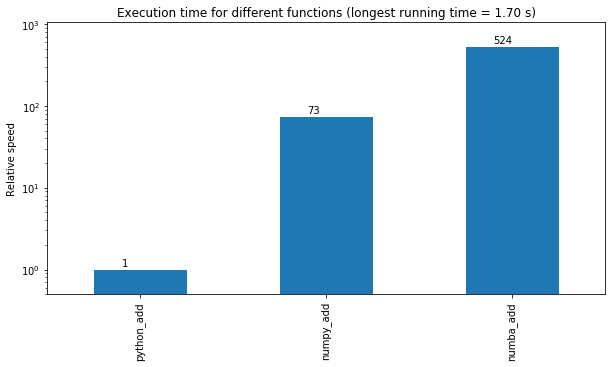

In [73]:
profile_add = [python_add, numpy_add, numba_add]
speeds_add = time_compare(profile_add, 10, 200000, n_runs=2)
plot_speeds(speeds_add)

Similar the case of MSE calculation, numpy provides significant speed-up, on the order of 70 times. But again numba gives much higher speeds-up which is **520**. This is **7** times faster as compared to code based on numpy arrays!

## Jaccard similarity example
To provide a comparison based on task more related to the Data Science, in the last example jaccard similarity function is calculated (jaccard similarity among columns of the 300x300 matrix). Such similarity function is very often used in classifications algorithms and recommendation systems.

In [74]:
def time_comp_jaccard(funcs, m, n_runs = 5):
    funcs_arr = []
    times_arr = []
    p = 0.95
    matrix = np.random.choice([0.0,1.0], size=(m,m), p=[p, 1 - p])

    for func in funcs:
        time_tot = 0
        np.random.seed(0)        
        res = func(matrix).sum().sum() #Initial execution, to force function comilation 
        for i in range(n_runs):
            np.random.seed(i) 
            start_time = timer()
            func(matrix)
            time_tot = time_tot + timer() - start_time
        times_arr = np.append(times_arr, time_tot/n_runs)
        funcs_arr = np.append(funcs_arr, func.__name__)
    return pd.DataFrame([times_arr.T], columns=funcs_arr).transpose()

In [75]:
def python_numpy_jaccard(M):
    u, i = M.shape
    dist = np.zeros((u,u))
    for i in range(u):
        for j in range(u):
            distance = (M[i]*M[j] > 0).sum()
            if distance:
                dist[i,j] = 1 - distance/((M[i] + M[j] > 0).sum())
            else: dist[i,j] = 1
    return dist

@njit
def numba_jaccard(M):
    u, i = M.shape
    dist = np.zeros((u,u))
    for i in range(u):
        for j in range(u):
            distance = (M[i]*M[j] > 0).sum()
            if distance:
                dist[i,j] = 1 - distance/((M[i] + M[j] > 0).sum())
            else: dist[i,j] = 1
    return dist

@njit(parallel=True)
def numba_parallel_jaccard(M):
    #here if first it is run with range, then it is very slow.
    #then one range is replaced with prange, then it crashes, and then to range again
    #and then it is fastest (3x faster than with prange)
    u, i = M.shape
    dist = np.zeros((u,u))
    for i in range(u):
        for j in range(u):
            distance = (M[i]*M[j] > 0).sum()
            if distance:
                dist[i,j] = 1 - distance/((M[i] + M[j] > 0).sum())
            else: dist[i,j] = 1
    return dist

@njit(parallel=True)
def numba_parallel_prange_jaccard(M):
    #this function at first run returns error, but on the second run it works ok.
    u, i = M.shape
    dist = np.zeros((u,u))
    #this time prange is used instead of range
    for i in prange(u):
        for j in range(u):
            distance = (M[i]*M[j] > 0).sum()
            if distance:
                dist[i,j] = 1 - distance/((M[i] + M[j] > 0).sum())
            else: dist[i,j] = 1
    return dist

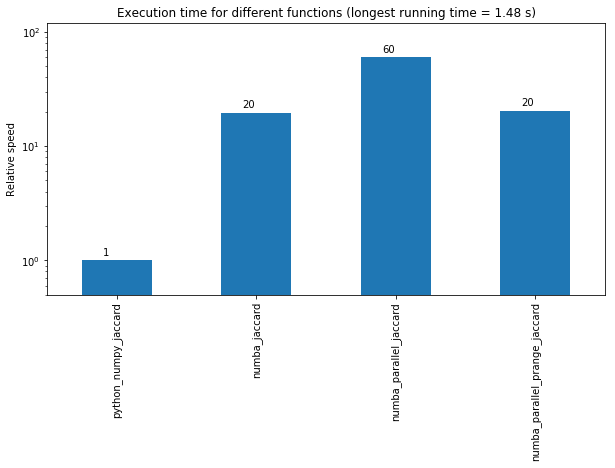

In [76]:
profile_jaccards = [python_numpy_jaccard, numba_jaccard, numba_parallel_jaccard, numba_parallel_prange_jaccard]
speeds_jaccards = time_comp_jaccard(profile_jaccards, 300, n_runs=2)
plot_speeds(speeds_jaccards)

As it can be noticed, also here the speeds gains offered with numba are the best. Here, the benchmark is provided by the hybrid python/numpy function (it is partially vectorized), still numba provides 20 time speed-up, when it runs without code parallelization, and up to 60 times faster runtime - when it is run with "experimental" parallelization option **@njit(parallel=True)**.  
Such option is still experimental and some problems exists when it is used. In my case the code throws error when executed for the firs time, but when it is executed for the second time it already works fine.  

Moreover, when function with **@njit(parallel=True)** and for loop uses regular "range" iterator then it works surprisingly slow (could be even slower than pure python code). 
In order to get advantage of the "for loop" parallelization "range" function should be replaced with "prange" (parallel range, numba function). But then on the first run code crashes. Then the second execution works fine, but the speed is similar to the one without **parallel=True** option. And the funny think is that when the "prange" is one more time replaced with "range" function, the the speed is 3 times faster as compared to not parallelized numba function. Thus it indicates although parallel numba option could provide even further speed gain, it should be used with care.

## Conclusions

In all the examples provided above numba decorator provided significant speed gains. It could over 700 times faster than a pure python code, and over 14 times faster than numpy code. Of course, such speed gains should not be expected in all cases and possibly could be specific to the examples presented above. Nevertheless, my motivation was to provide speed gains offered by numba package on some typical and simple to reproduce examples.

I would be glad to hear your comments on that package and I am curious what speed gains do you get!